libraries

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import umap.umap_ as umap
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

Model structure in detail :

In [2]:
class DCIM(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate=9):
        super(DCIM, self).__init__()
      

        # Depthwise: out_channels = in_channels (per-channel conv)

        self.depthwise = nn.Conv1d(in_channels,out_channels, kernel_size=3,dilation=dilation_rate,padding='same', groups=in_channels,bias=False)

        # pointwise: mixes channels, produces out_channels

        self.pointwise = nn.Conv1d(in_channels , out_channels , kernel_size=1 , bias=False)


        self.bn_dw = nn.BatchNorm1d(out_channels)
        self.bn_pw = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm1d(out_channels)
 
        self.gap = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
    
        # 1) depthwise (dilated)
        d = self.depthwise(x)
        d = self.bn_dw(d)
        d = self.relu(d)

      
        # 2) pointwise on z

        p = self.pointwise(d)
       
        out = self.bn(p)
        out = self.relu(out)
        # 3) golobal avrage pooling
        x = self.gap(out)            

        return x
    

class DSICNN(nn.Module):

    def __init__(self, num_classes):
        super(DSICNN, self).__init__()
       
        self.conv1 = nn.Conv1d(1, 16, kernel_size=64)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=4)

        self.conv2 = nn.Conv1d(16, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=4)

        self.dlicm1 = DCIM(64, 64, dilation_rate=9)

        self.fc = nn.Linear(64, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        
        x = x.unsqueeze(1)  

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.dlicm1(x)
        x = x.squeeze(-1)         
        x = self.fc(x)           
        return x    
    

def train_and_evaluate(model, num_epochs, train_loader, val_loader,
                       criterion, optimizer, scheduler=None, device='cpu'):
    model.to(device)
    loss_hist_train, acc_hist_train = [], []
    loss_hist_val, acc_hist_val = [], []

    for epoch in range(num_epochs):
       
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            bs = yb.size(0)
            running_loss += loss.item() * bs
            running_corrects += (preds.argmax(dim=1) == yb).sum().item()
            total_samples += bs

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples
        loss_hist_train.append(epoch_train_loss)
        acc_hist_train.append(epoch_train_acc)

     
        model.eval()
        val_loss_sum = 0.0
        val_corrects = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                bs = yb.size(0)
                val_loss_sum += loss.item() * bs
                val_corrects += (preds.argmax(dim=1) == yb).sum().item()
                val_total += bs

        epoch_val_loss = val_loss_sum / val_total
        epoch_val_acc = val_corrects / val_total

        loss_hist_val.append(epoch_val_loss)
        acc_hist_val.append(epoch_val_acc)

        # scheduler step
        if scheduler is not None:
            scheduler.step(epoch_val_loss)

        print(f"Epoch[{epoch+1:3d}]: T_Acc={epoch_train_acc:.4f} T_Loss={epoch_train_loss:.4f} | V_Acc={epoch_val_acc:.4f} V_Loss={epoch_val_loss:.4f}")

    return loss_hist_train, acc_hist_train, loss_hist_val, acc_hist_val


Data preprocessing...

In [ ]:
df = pd.read_pickle('C:/Users/Albaloo Rayaneh/Desktop/گزارش/MODEL/CWRU-Thesies/noisy/800NoisySignals_1024_noisy_-6.pkl')


X = np.array(df['Signal'].tolist())
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42 , stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Model tuning :

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 400
set_seed(42)
model = DSICNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [ ]:
train_loss, train_acc, val_loss, val_acc = train_and_evaluate(model,num_epochs, train_loader, val_loader,criterion, optimizer, scheduler, device=device)

Reports And Diagrams ...

In [7]:
model_name = "DSI-CNN"
noise_level = "-6"   
# noise_level = ""  

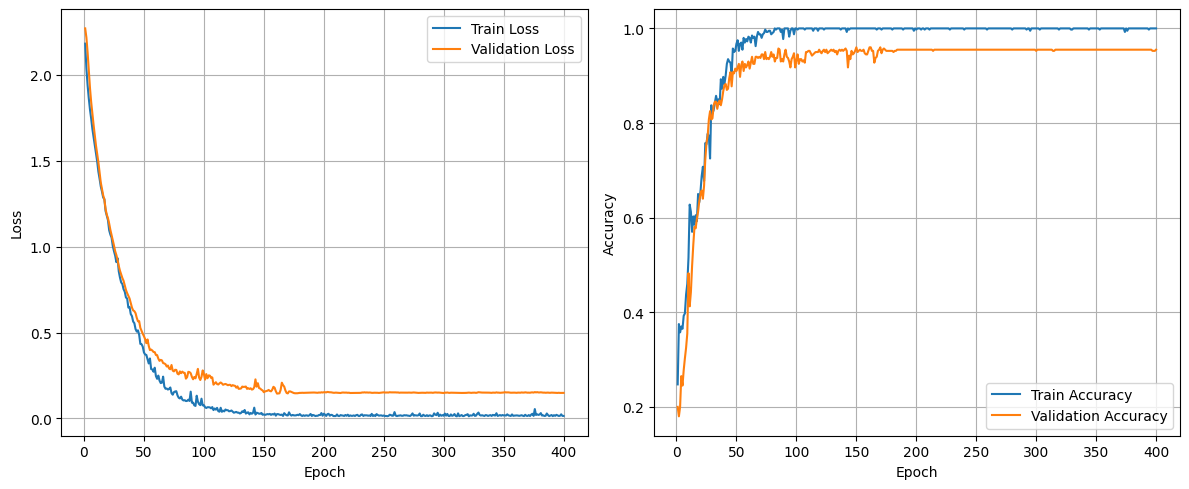

In [9]:
full_model_name = f"{model_name}-SNR_({noise_level})" if noise_level != "" else model_name


title_loss = f"Loss of {full_model_name}"
title_acc = f"Accuracy of {full_model_name}"
file_name  = f"Accuracy_and_Loss_of_{full_model_name}.png"


epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.title(title_loss)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.title(title_acc)
plt.grid(True)

plt.tight_layout()
# plt.savefig(file_name, dpi=300, bbox_inches='tight')
plt.show()


Accuracy:      0.9550
Precision:     0.9591
Recall:        0.9550
F1-score:      0.9550
Cohen's Kappa: 0.9500

Classification Report of DSI-CNN-SNR_(-6):
              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        40
           1     0.9737    0.9250    0.9487        40
           2     0.9697    0.8000    0.8767        40
           3     0.8125    0.9750    0.8864        40
           4     1.0000    1.0000    1.0000        40
           5     1.0000    0.9750    0.9873        40
           6     0.9756    1.0000    0.9877        40
           7     1.0000    0.9000    0.9474        40
           8     1.0000    1.0000    1.0000        40
           9     0.9070    0.9750    0.9398        40

    accuracy                         0.9550       400
   macro avg     0.9591    0.9550    0.9550       400
weighted avg     0.9591    0.9550    0.9550       400



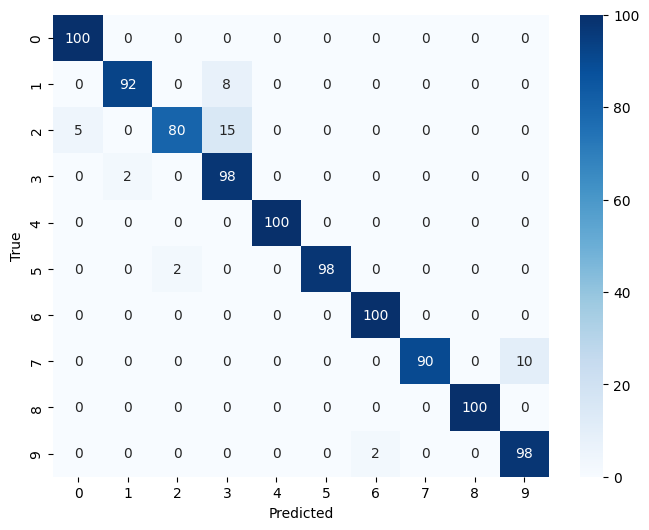

DSI-CNN
FLOPs: 2,125,312.0
Parameters: 9,530.0
Model Size: 0.05 MB


In [10]:
import os
import time
import seaborn as sns
from thop import profile
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

X_test = X_test.to(device)
y_test = y_test.to(device)

full_model_name = f"{model_name}-SNR_({noise_level})" if noise_level != "" else model_name

# 1) پیش‌بینی روی داده تست
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(1).cpu().numpy()
    y_true = y_test.cpu().numpy()

# 2) معیارهای کلی
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1-score:      {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# 3) گزارش کامل هر کلاس
print(f"\nClassification Report of {full_model_name}:")
print(classification_report(y_true, y_pred, digits=4))

# 4) ماتریس اغتشاش درصدی
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".0f", cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.title(f"Confusion Matrix - {full_model_name}")
plt.savefig(f"confusion_matrix_{full_model_name}.png", dpi=300, bbox_inches='tight')
plt.show()

# 5) محاسبه FLOPs و تعداد پارامترها
dummy_input = torch.randn(1, X_test.shape[1]).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"{model_name}")
print(f"FLOPs: {flops:,}")
print(f"Parameters: {params:,}")

# 6) حجم مدل
model_path = f"temp_{full_model_name}.pth"
torch.save(model.state_dict(), model_path)
model_size = os.path.getsize(model_path) / (1024**2)
print(f"Model Size: {model_size:.2f} MB")


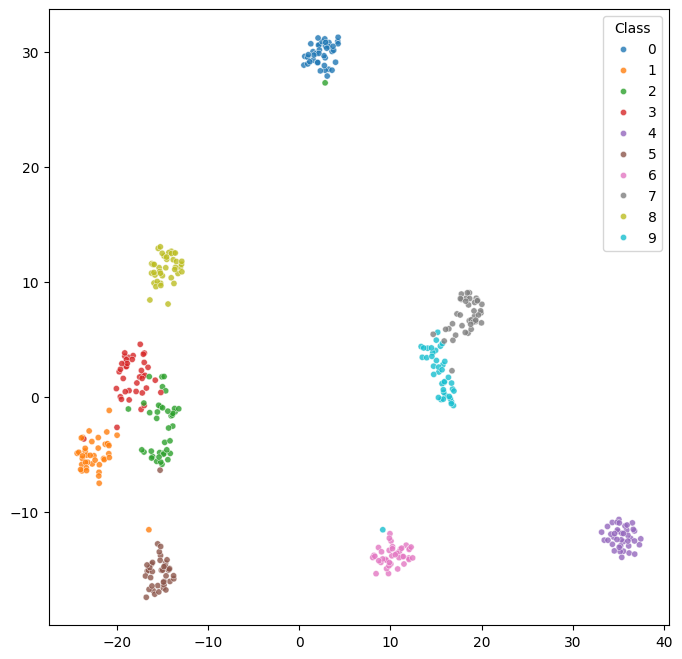

c:\Users\Albaloo Rayaneh\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


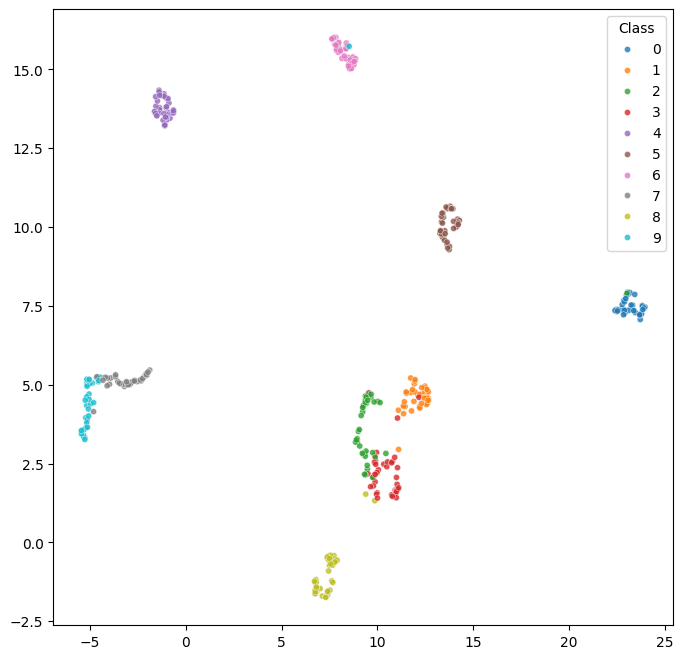

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            model.conv1, model.bn1, model.relu, model.pool1,
            model.conv2, model.bn2, model.relu, model.pool2,
            model.dlicm1
           
        )
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.features(x)
        return x.squeeze(-1)

extractor = FeatureExtractor(model).to(device)
extractor.eval()
with torch.no_grad():
    features = extractor(X_test).cpu().numpy()
    labels = y_test.cpu().numpy()

# t-SNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8,8))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels,
                palette="tab10", s=20, alpha=0.8)
# plt.title("t-SNE Visualization of Features")
plt.legend(title="Class")
plt.savefig(f"t-SNE_{full_model_name}.png", dpi=300, bbox_inches='tight')
plt.show()

# UMAP 
reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = reducer.fit_transform(features)

plt.figure(figsize=(8,8))
sns.scatterplot(x=features_umap[:,0], y=features_umap[:,1], hue=labels,
                palette="tab10", s=20, alpha=0.8)
# plt.title("UMAP Visualization of Features")
plt.legend(title="Class")

plt.savefig(f"UMAP_{full_model_name}.png", dpi=300, bbox_inches='tight')

plt.show()
